In [1]:
import numpy as np
import pandas as pd
import glob
import arff
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
def run_k_fold_rf(X, Y):
    indexes_list = list(range(0, len(X)))

    random.shuffle(indexes_list)

    indexes_list = np.array_split(indexes_list, 10)
    
    r_squared_scores_list = []

    for k_fold_index in range(0, 10):
        print("========== FOLD N°" + str(k_fold_index) + " ==========")

        # Get the training and testing indexes based on the k_fold_indexes and the k_fold_index
        train_indexes = []
        test_indexes = []
        for group in range(10):
            if group == k_fold_index:
                test_indexes.append(indexes_list[group])
            else:
                train_indexes.append(indexes_list[group])
        train_indexes = np.concatenate(train_indexes).ravel()  # Ravel the list of lists of indexes
        test_indexes = np.concatenate(test_indexes).ravel()
        
        X_train, Y_train = X.iloc[train_indexes].copy(), np.array(Y.iloc[train_indexes])
        X_test, Y_test = X.iloc[test_indexes].copy(), np.array(Y.iloc[test_indexes])

        model = LinearRegression(n_jobs=-1)

        model.fit(X_train, Y_train)
        
        prediction = model.predict(X_test)
        
        r_squared_score = r2_score(Y_test, prediction)
        r_squared_scores_list.append(r_squared_score)
        
        print('Test R² : ' + str(r_squared_score))
        
    print('Mean R² : ' + str(np.mean(r_squared_scores_list)))

## 1) Bias_correction_of_numerical_prediction_model temperature_forecast_Dataset

In [3]:
tmp_df = pd.read_csv('../data/raw/Bias_correction_of_numerical_prediction_model temperature_forecast_Dataset/Bias_correction_ucl.csv')
print(tmp_df.shape)

(7752, 25)


In [4]:
tmp_df.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [5]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


In [6]:
tmp_df.isna().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

In [7]:
tmp_df.dropna(inplace=True)
tmp_df.shape

(7588, 25)

In [8]:
tmp_df.drop(['Date'], axis=1, inplace=True)

In [9]:
tmp_df.drop(['Next_Tmin'], axis=1, inplace=True)  # We will only try to predict Next_Tmax

<AxesSubplot:>

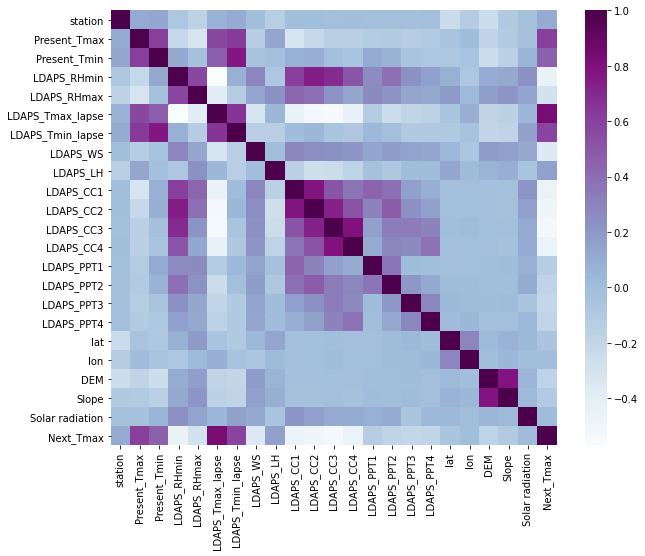

In [10]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=tmp_df.corr(), cmap='BuPu')

In [11]:
X = tmp_df.drop(['Next_Tmax'], axis=1)
Y = tmp_df['Next_Tmax']

In [12]:
# Target variable index :
print(tmp_df.columns.get_loc('Next_Tmax'))

22


In [13]:
run_k_fold_rf(X, Y)

========== FOLD N°0 ==========
Test R² : 0.7589035935246399
========== FOLD N°1 ==========
Test R² : 0.8024811146224777
========== FOLD N°2 ==========
Test R² : 0.7804848109662506
========== FOLD N°3 ==========
Test R² : 0.7470429632992408
========== FOLD N°4 ==========
Test R² : 0.7825120300632045
========== FOLD N°5 ==========
Test R² : 0.763493758906753
========== FOLD N°6 ==========
Test R² : 0.7740588612408505
========== FOLD N°7 ==========
Test R² : 0.7929586836535993
========== FOLD N°8 ==========
Test R² : 0.8101218487644619
========== FOLD N°9 ==========
Test R² : 0.7831660935627278
Mean R² : 0.7795223758604206


In [14]:
tmp_df.to_csv(path_or_buf='../data/cleaned/Bias_correction_ucl/data.csv', index=False)

## 2) clickstream_data_for_online_shopping_Dataset

In [15]:
# Unusable

## 3) Electrical_Grid_Stability_Simulated_Dataset

In [16]:
tmp_df = pd.read_csv('../data/raw/Electrical_Grid_Stability_Simulated_Dataset/Data_for_UCI_named.csv')
print(tmp_df.shape)

(10000, 14)


In [17]:
tmp_df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [18]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [19]:
tmp_df.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [20]:
tmp_df.drop(['stabf'], axis=1, inplace=True)

<AxesSubplot:>

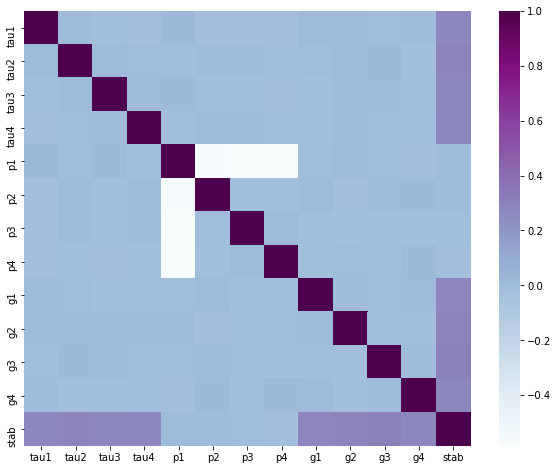

In [21]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=tmp_df.corr(), cmap='BuPu')

In [22]:
X = tmp_df.drop(['stab'], axis=1)
Y = tmp_df['stab']

In [23]:
# Target variable index :
print(tmp_df.columns.get_loc('stab'))

12


In [24]:
run_k_fold_rf(X, Y)

========== FOLD N°0 ==========
Test R² : 0.64268931743905
========== FOLD N°1 ==========
Test R² : 0.653455071297316
========== FOLD N°2 ==========
Test R² : 0.6418567369686241
========== FOLD N°3 ==========
Test R² : 0.6541508391046891
========== FOLD N°4 ==========
Test R² : 0.6469217865186419
========== FOLD N°5 ==========
Test R² : 0.6342484498573728
========== FOLD N°6 ==========
Test R² : 0.6265548147314595
========== FOLD N°7 ==========
Test R² : 0.6753737915732405
========== FOLD N°8 ==========
Test R² : 0.646431518587407
========== FOLD N°9 ==========
Test R² : 0.6333010175792275
Mean R² : 0.6454983343657028


In [25]:
tmp_df.to_csv(path_or_buf='../data/cleaned/Electrical_Grid_Stability_Simulated_Dataset/data.csv', index=False)

## 4) Gas_Turbine_CO_and_NOx_Emission_Dataset

In [26]:
tmp_df_1 = pd.read_csv('Gas_Turbine_CO_and_NOx_Emission_Dataset/gt_2011.csv')
tmp_df_2 = pd.read_csv('Gas_Turbine_CO_and_NOx_Emission_Dataset/gt_2012.csv')
tmp_df_3 = pd.read_csv('Gas_Turbine_CO_and_NOx_Emission_Dataset/gt_2013.csv')
tmp_df_4 = pd.read_csv('Gas_Turbine_CO_and_NOx_Emission_Dataset/gt_2014.csv')
tmp_df_5 = pd.read_csv('Gas_Turbine_CO_and_NOx_Emission_Dataset/gt_2015.csv')

tmp_df = pd.concat([tmp_df_1, tmp_df_2, tmp_df_3, tmp_df_4, tmp_df_5], axis=0)
print(tmp_df.shape)

(36733, 11)


In [27]:
tmp_df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028


In [28]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36733 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.4 MB


In [29]:
tmp_df.isna().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

<AxesSubplot:>

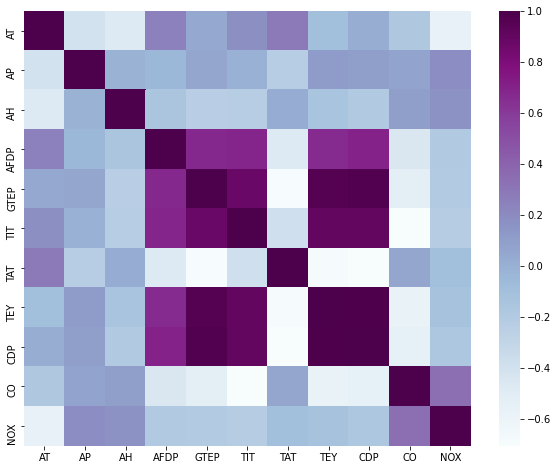

In [30]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=tmp_df.corr(), cmap='BuPu')

In [31]:
X = tmp_df.drop(['TEY'], axis=1)
Y = tmp_df['TEY']

In [32]:
run_k_fold_rf(X, Y)

========== FOLD N°0 ==========
Test R² : 0.9964226669147971
========== FOLD N°1 ==========
Test R² : 0.9962549166991556
========== FOLD N°2 ==========
Test R² : 0.9963491925413988
========== FOLD N°3 ==========
Test R² : 0.996445737721315
========== FOLD N°4 ==========
Test R² : 0.9963276571914105
========== FOLD N°5 ==========
Test R² : 0.9962171344478415
========== FOLD N°6 ==========
Test R² : 0.9963617660094951
========== FOLD N°7 ==========
Test R² : 0.9961689121634725
========== FOLD N°8 ==========
Test R² : 0.9962304072930552
========== FOLD N°9 ==========
Test R² : 0.9961424922943489
Mean R² : 0.9962920883276289


## 5) Seoul_Bike_Sharing_Demand_Dataset

In [33]:
tmp_df = pd.read_csv('../data/raw/Seoul_Bike_Sharing_Demand_Dataset/SeoulBikeData.csv', encoding='iso8859-1')
print(tmp_df.shape)

(8760, 14)


In [34]:
tmp_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [35]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [36]:
tmp_df.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

<AxesSubplot:>

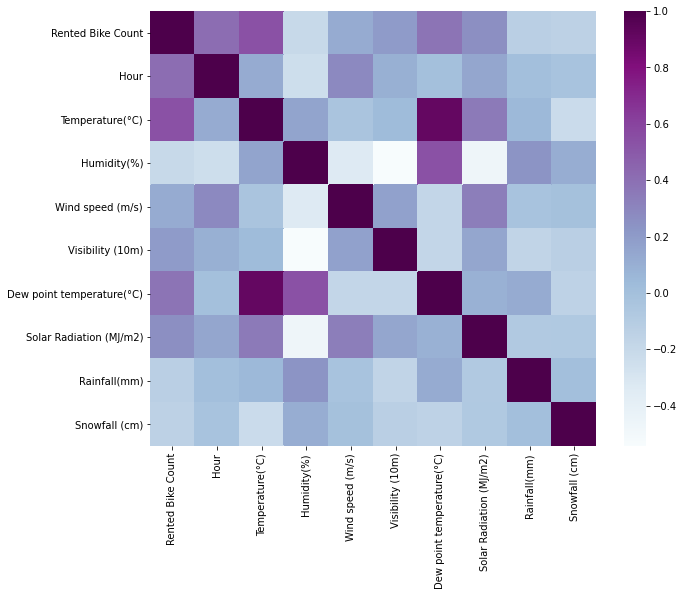

In [37]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=tmp_df.corr(), cmap='BuPu')

In [38]:
tmp_df.drop(['Date', 'Seasons', 'Holiday', 'Functioning Day'], axis=1, inplace=True)

In [39]:
Y = tmp_df['Rented Bike Count']
X = tmp_df.drop(['Rented Bike Count'], axis=1)

In [40]:
# Target variable index :
print(tmp_df.columns.get_loc('Rented Bike Count'))

0


In [41]:
run_k_fold_rf(X, Y)

========== FOLD N°0 ==========
Test R² : 0.44193058666004903
========== FOLD N°1 ==========
Test R² : 0.48714070595160086
========== FOLD N°2 ==========
Test R² : 0.5003828713084469
========== FOLD N°3 ==========
Test R² : 0.4370155237477743
========== FOLD N°4 ==========
Test R² : 0.4723154971473591
========== FOLD N°5 ==========
Test R² : 0.46010851837859323
========== FOLD N°6 ==========
Test R² : 0.500103961719967
========== FOLD N°7 ==========
Test R² : 0.4709441195613643
========== FOLD N°8 ==========
Test R² : 0.48565732734922273
========== FOLD N°9 ==========
Test R² : 0.4340697665959973
Mean R² : 0.4689668878420375


In [42]:
tmp_df.to_csv(path_or_buf='../data/cleaned/Seoul_Bike_Sharing_Demand_Dataset/data.csv', index=False)

## 6) SGEMM_GPU_kernel_performance_Dataset

In [43]:
tmp_df = pd.read_csv('../data/raw/SGEMM_GPU_kernel_performance_Dataset/sgemm_product.csv', encoding='iso8859-1')
print(tmp_df.shape)

(241600, 18)


In [44]:
tmp_df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [45]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MWG        241600 non-null  int64  
 1   NWG        241600 non-null  int64  
 2   KWG        241600 non-null  int64  
 3   MDIMC      241600 non-null  int64  
 4   NDIMC      241600 non-null  int64  
 5   MDIMA      241600 non-null  int64  
 6   NDIMB      241600 non-null  int64  
 7   KWI        241600 non-null  int64  
 8   VWM        241600 non-null  int64  
 9   VWN        241600 non-null  int64  
 10  STRM       241600 non-null  int64  
 11  STRN       241600 non-null  int64  
 12  SA         241600 non-null  int64  
 13  SB         241600 non-null  int64  
 14  Run1 (ms)  241600 non-null  float64
 15  Run2 (ms)  241600 non-null  float64
 16  Run3 (ms)  241600 non-null  float64
 17  Run4 (ms)  241600 non-null  float64
dtypes: float64(4), int64(14)
memory usage: 33.2 MB


In [46]:
tmp_df.isna().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64

In [47]:
tmp_df.drop(['Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis=1, inplace=True)  # We will only predict the first variable to regress

<AxesSubplot:>

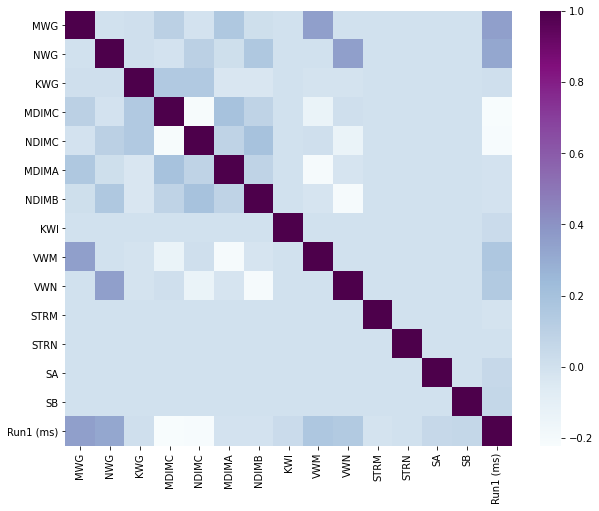

In [48]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=tmp_df.corr(), cmap='BuPu')

In [49]:
X = tmp_df.drop(['Run1 (ms)'], axis=1)
Y = tmp_df['Run1 (ms)']

In [50]:
# Target variable index :
print(tmp_df.columns.get_loc('Run1 (ms)'))

14


In [51]:
run_k_fold_rf(X, Y)

========== FOLD N°0 ==========
Test R² : 0.4079870486537108
========== FOLD N°1 ==========
Test R² : 0.4117097886236364
========== FOLD N°2 ==========
Test R² : 0.4067895525904779
========== FOLD N°3 ==========
Test R² : 0.4133702948246193
========== FOLD N°4 ==========
Test R² : 0.40999907385937917
========== FOLD N°5 ==========
Test R² : 0.4055356127302253
========== FOLD N°6 ==========
Test R² : 0.4023917912803575
========== FOLD N°7 ==========
Test R² : 0.4054413890904368
========== FOLD N°8 ==========
Test R² : 0.4083823621784499
========== FOLD N°9 ==========
Test R² : 0.40350716327149894
Mean R² : 0.40751140771027927


In [52]:
tmp_df.to_csv(path_or_buf='../data/cleaned/SGEMM_GPU_kernel_performance_Dataset/data.csv', index=False)

## 7) Superconductivty_Dataset

In [53]:
X = pd.read_csv('Superconductivty_Dataset/train.csv')
print(X.shape)

Y = pd.read_csv('Superconductivty_Dataset/unique_m.csv', usecols=['critical_temp'])
print(Y.shape)

(21263, 82)
(21263, 1)


In [54]:
X.isna().sum()

number_of_elements       0
mean_atomic_mass         0
wtd_mean_atomic_mass     0
gmean_atomic_mass        0
wtd_gmean_atomic_mass    0
                        ..
range_Valence            0
wtd_range_Valence        0
std_Valence              0
wtd_std_Valence          0
critical_temp            0
Length: 82, dtype: int64

In [55]:
Y.isna().sum()

critical_temp    0
dtype: int64

In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

In [57]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   critical_temp  21263 non-null  float64
dtypes: float64(1)
memory usage: 166.2 KB


<AxesSubplot:>

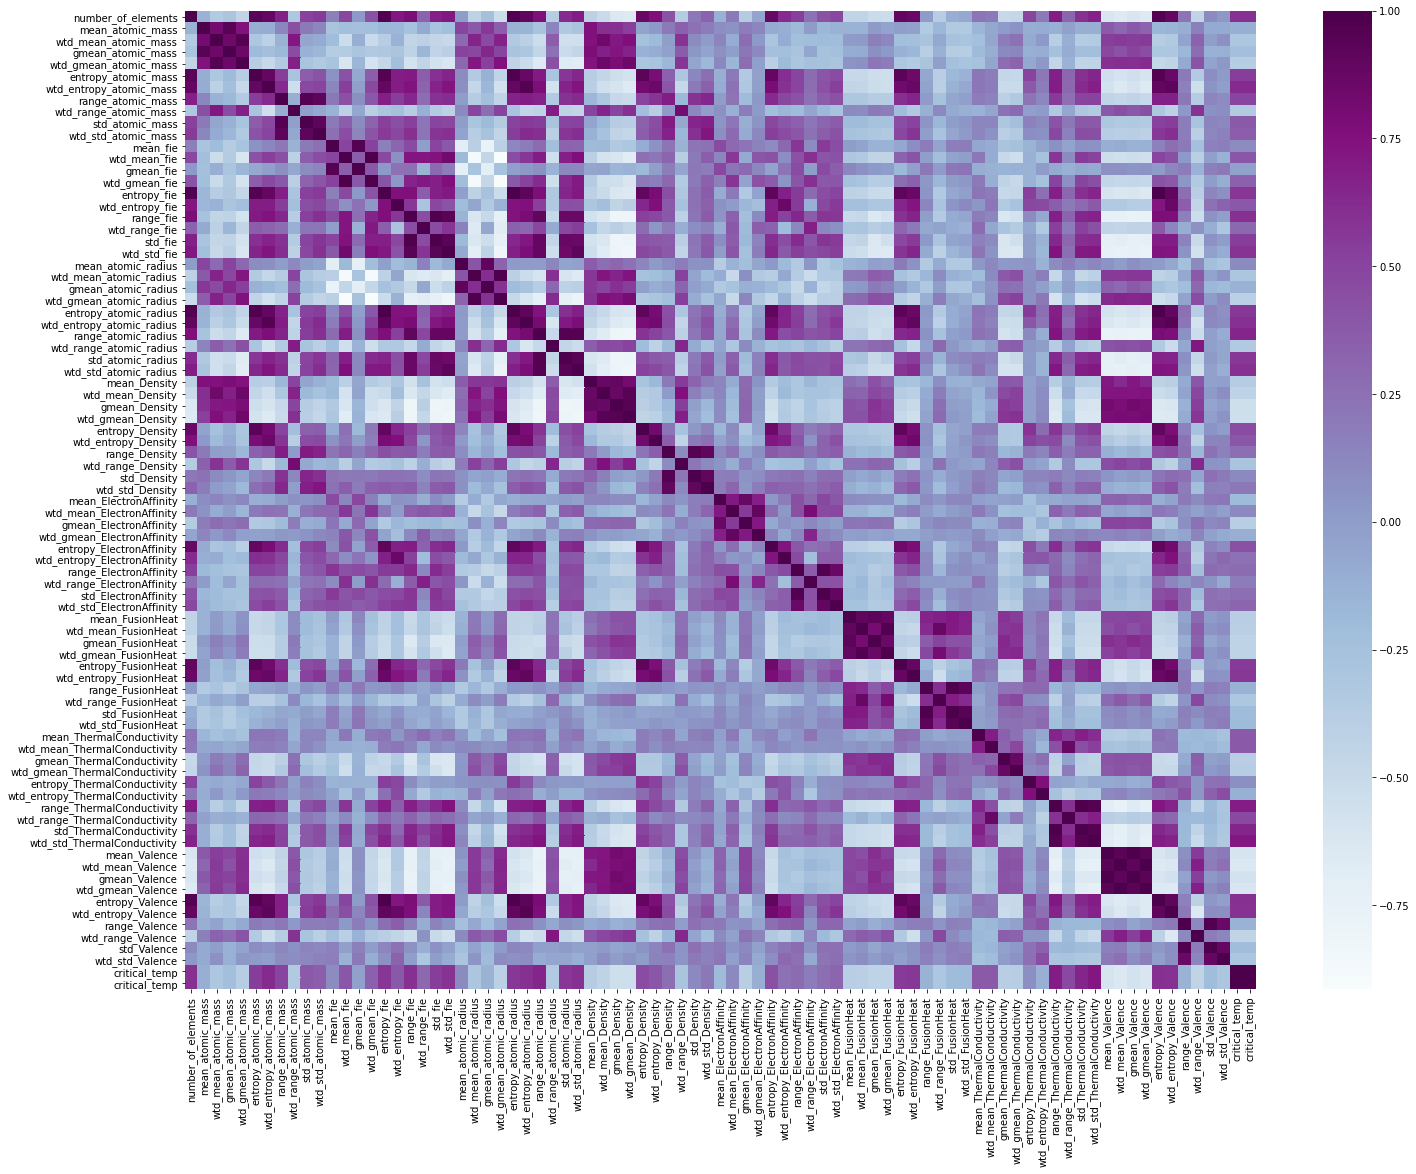

In [58]:
plt.subplots(figsize=(24,18))
sns.heatmap(data=pd.concat([X, Y], axis=1).corr(), cmap='BuPu')

In [59]:
run_k_fold_rf(X, Y['critical_temp'])

========== FOLD N°0 ==========
Test R² : 1.0
========== FOLD N°1 ==========
Test R² : 1.0
========== FOLD N°2 ==========
Test R² : 1.0
========== FOLD N°3 ==========
Test R² : 1.0
========== FOLD N°4 ==========
Test R² : 1.0
========== FOLD N°5 ==========
Test R² : 1.0
========== FOLD N°6 ==========
Test R² : 1.0
========== FOLD N°7 ==========
Test R² : 1.0
========== FOLD N°8 ==========
Test R² : 1.0
========== FOLD N°9 ==========
Test R² : 1.0
Mean R² : 1.0


## 8) Financial Indicators of US stocks

In [60]:
files = glob.glob("Financial_Indicators_of_US_stocks/*.csv")
dfs = [pd.read_csv(f) for f in files]
tmp_df = pd.concat(dfs, axis=0, ignore_index=True)
tmp_df.shape

(22077, 229)

In [61]:
tmp_df.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class,2015 PRICE VAR [%],2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%]
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,...,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1,NaN,NaN,NaN,NaN
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,...,-0.0137,0.0000,-0.1265,Energy,40.588068,1,NaN,NaN,NaN,NaN
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,...,-0.0169,0.0390,-0.0942,Technology,30.295514,1,NaN,NaN,NaN,NaN
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,...,-0.5841,0.1738,0.0942,Technology,64.213737,1,NaN,NaN,NaN,NaN
4,GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,...,-0.2297,0.0000,0.0308,Industrials,44.757840,1,NaN,NaN,NaN,NaN


In [62]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

tmp_df.isna().sum().sort_values()

Unnamed: 0                                        0
Class                                             0
Sector                                            0
Financing Cash Flow                             972
Net cash flow / Change in cash                 1018
Operating Income                               1101
Receivables                                    1105
Retained earnings (deficit)                    1167
Operating Cash Flow                            1168
Revenue                                        1171
Cash and cash equivalents                      1179
Earnings Before Tax Margin                     1195
Gross Margin                                   1199
Gross Profit                                   1207
EPS Diluted                                    1292
EPS                                            1301
Total assets                                   1305
Earnings before Tax                            1364
Total shareholders equity                      1372
Net Income C

Missing too many values...

## 9) Production Quality

In [63]:
X = pd.read_csv('../data/raw/Production_quality/data_X.csv')
print(X.shape)

Y = pd.read_csv('../data/raw/Production_quality/data_Y.csv')
print(Y.shape)

(2103841, 18)
(29184, 2)


In [64]:
X.head()

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


In [65]:
Y.head()

,date_time,quality
0,2015-01-04 00:05:00,392
1,2015-01-04 01:05:00,384
2,2015-01-04 02:05:00,393
3,2015-01-04 03:05:00,399
4,2015-01-04 04:05:00,400


In [66]:
tmp_df = X.merge(Y, on='date_time', how='inner')

In [67]:
tmp_df.shape

(29184, 19)

In [68]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29184 entries, 0 to 29183
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_time   29184 non-null  object 
 1   T_data_1_1  29184 non-null  int64  
 2   T_data_1_2  29184 non-null  int64  
 3   T_data_1_3  29184 non-null  int64  
 4   T_data_2_1  29184 non-null  int64  
 5   T_data_2_2  29184 non-null  int64  
 6   T_data_2_3  29184 non-null  int64  
 7   T_data_3_1  29184 non-null  int64  
 8   T_data_3_2  29184 non-null  int64  
 9   T_data_3_3  29184 non-null  int64  
 10  T_data_4_1  29184 non-null  int64  
 11  T_data_4_2  29184 non-null  int64  
 12  T_data_4_3  29184 non-null  int64  
 13  T_data_5_1  29184 non-null  int64  
 14  T_data_5_2  29184 non-null  int64  
 15  T_data_5_3  29184 non-null  int64  
 16  H_data      29184 non-null  float64
 17  AH_data     29184 non-null  float64
 18  quality     29184 non-null  int64  
dtypes: float64(2), int64(16),

In [69]:
tmp_df.drop(['date_time'], axis=1, inplace=True)

In [70]:
tmp_df.isna().sum()

T_data_1_1    0
T_data_1_2    0
T_data_1_3    0
T_data_2_1    0
T_data_2_2    0
T_data_2_3    0
T_data_3_1    0
T_data_3_2    0
T_data_3_3    0
T_data_4_1    0
T_data_4_2    0
T_data_4_3    0
T_data_5_1    0
T_data_5_2    0
T_data_5_3    0
H_data        0
AH_data       0
quality       0
dtype: int64

<AxesSubplot:>

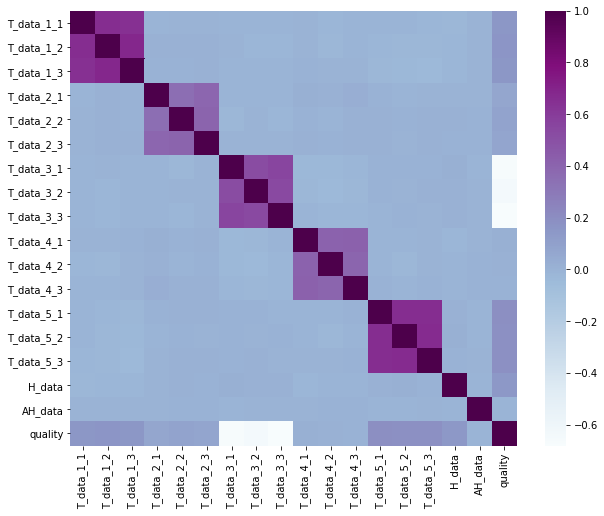

In [71]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=tmp_df.corr(), cmap='BuPu')

In [72]:
X = tmp_df.drop(['quality'], axis=1)
Y = tmp_df['quality']

In [73]:
# Target variable index :
print(tmp_df.columns.get_loc('quality'))

17


In [74]:
run_k_fold_rf(X, Y)

========== FOLD N°0 ==========
Test R² : 0.752400053815016
========== FOLD N°1 ==========
Test R² : 0.7583615849169031
========== FOLD N°2 ==========
Test R² : 0.7578591930450407
========== FOLD N°3 ==========
Test R² : 0.7532871226713145
========== FOLD N°4 ==========
Test R² : 0.7478286219789587
========== FOLD N°5 ==========
Test R² : 0.717877546685564
========== FOLD N°6 ==========
Test R² : 0.6762370993464271
========== FOLD N°7 ==========
Test R² : 0.776016261211006
========== FOLD N°8 ==========
Test R² : 0.7579473020742454
========== FOLD N°9 ==========
Test R² : 0.7689887829618676
Mean R² : 0.7466803568706343


In [75]:
tmp_df.to_csv(path_or_buf='../data/cleaned/Production_quality/data.csv', index=False)

## 10) Seoul Bike trip duration 

In [76]:
tmp_df = pd.read_csv('Seoul_Bike_trip_duration/For_modeling.csv')
print(tmp_df.shape)

(9601139, 26)


In [77]:
tmp_df.head()

,Unnamed: 0,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Pmonth,Pday,Phour,Pmin,PDweek,Dmonth,Dday,Dhour,Dmin,DDweek,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust
0,0,3,50,37.544666,126.888359,37.544666,126.888359,0.000000,1,1,0,0,0,1,1,0,4,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
1,1,24,7670,37.506199,127.003944,37.551250,127.035103,5.713529,1,1,0,0,0,1,1,0,25,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
2,2,8,1390,37.544590,127.057083,37.537014,127.061096,0.913702,1,1,0,0,0,1,1,0,9,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
3,3,8,1820,37.571102,127.023560,37.561447,127.034920,1.468027,1,1,0,1,0,1,1,0,10,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
4,4,4,850,37.573242,127.015907,37.565849,127.016403,0.823227,1,1,0,1,0,1,1,0,6,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0


In [78]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601139 entries, 0 to 9601138
Data columns (total 26 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   Duration    int64  
 2   Distance    int64  
 3   PLong       float64
 4   PLatd       float64
 5   DLong       float64
 6   DLatd       float64
 7   Haversine   float64
 8   Pmonth      int64  
 9   Pday        int64  
 10  Phour       int64  
 11  Pmin        int64  
 12  PDweek      int64  
 13  Dmonth      int64  
 14  Dday        int64  
 15  Dhour       int64  
 16  Dmin        int64  
 17  DDweek      int64  
 18  Temp        float64
 19  Precip      float64
 20  Wind        float64
 21  Humid       float64
 22  Solar       float64
 23  Snow        float64
 24  GroundTemp  float64
 25  Dust        float64
dtypes: float64(13), int64(13)
memory usage: 1.9 GB


In [79]:
tmp_df.isna().sum()

Unnamed: 0    0
Duration      0
Distance      0
PLong         0
PLatd         0
DLong         0
DLatd         0
Haversine     0
Pmonth        0
Pday          0
Phour         0
Pmin          0
PDweek        0
Dmonth        0
Dday          0
Dhour         0
Dmin          0
DDweek        0
Temp          0
Precip        0
Wind          0
Humid         0
Solar         0
Snow          0
GroundTemp    0
Dust          0
dtype: int64

In [80]:
tmp_df.drop(['Unnamed: 0'], axis=1, inplace=True)

<AxesSubplot:>

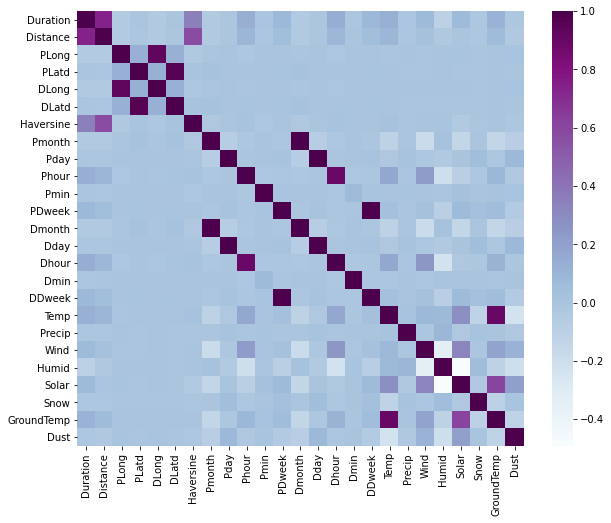

In [81]:
plt.subplots(figsize=(10,8))
sns.heatmap(data=tmp_df.corr(), cmap='BuPu')

In [82]:
tmp_df = tmp_df[0:100000]

In [83]:
tmp_df.shape

(100000, 25)

In [84]:
X = tmp_df.drop(['Duration'], axis=1)
Y = tmp_df['Duration']

In [85]:
run_k_fold_rf(X, Y)

========== FOLD N°0 ==========
Test R² : 0.933993827839034
========== FOLD N°1 ==========
Test R² : 0.8907802858906746
========== FOLD N°2 ==========
Test R² : 0.9772988765606326
========== FOLD N°3 ==========
Test R² : 0.9758458383268229
========== FOLD N°4 ==========
Test R² : 0.9172358711930704
========== FOLD N°5 ==========
Test R² : 0.8392231366186391
========== FOLD N°6 ==========
Test R² : 0.9836856089219187
========== FOLD N°7 ==========
Test R² : 0.9714850673365314
========== FOLD N°8 ==========
Test R² : 0.9084280608864548
========== FOLD N°9 ==========
Test R² : 0.9069426473094976
Mean R² : 0.9304919220883276


## 11) Uber_location_price_data

In [86]:
tmp_df = pd.read_csv('../data/raw/Uber_location_price_data/cleaned_2.csv', delimiter=';', decimal=',')
print(tmp_df.shape)

(205670, 8)


In [87]:
tmp_df.head()

,Unnamed: 0,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,10.5,2011-04-18 19:55:00 UTC,-73.984565,40.745372,-73.951843,40.777743,5
1,1,12.0,2014-01-09 07:48:00 UTC,-73.991572,40.749877,-73.964142,40.757180,1
2,2,9.0,2014-09-14 01:14:00 UTC,-74.000412,40.718410,-73.999255,40.719967,2
3,3,9.3,2012-03-18 15:04:01 UTC,-73.991999,40.719834,-73.983515,40.743818,1
4,4,8.5,2012-02-06 13:09:00 UTC,-73.966765,40.761547,-73.990493,40.750787,1


In [88]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205670 entries, 0 to 205669
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         205670 non-null  int64  
 1   fare_amount        205670 non-null  float64
 2   pickup_datetime    205670 non-null  object 
 3   pickup_longitude   205670 non-null  float64
 4   pickup_latitude    205670 non-null  float64
 5   dropoff_longitude  205670 non-null  float64
 6   dropoff_latitude   205670 non-null  float64
 7   passenger_count    205670 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 12.6+ MB


In [89]:
tmp_df.isna().sum()

Unnamed: 0           0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [90]:
tmp_df.drop(['pickup_datetime', 'Unnamed: 0'], axis=1, inplace=True)

<AxesSubplot:>

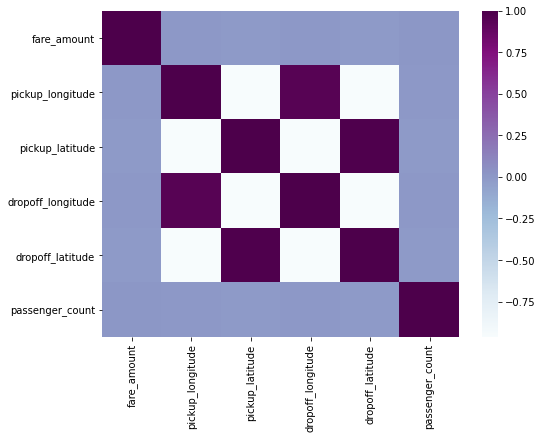

In [91]:
plt.subplots(figsize=(8,6))
sns.heatmap(data=tmp_df.corr(), cmap='BuPu')

In [92]:
X = tmp_df.drop(['fare_amount'], axis=1)
Y = tmp_df['fare_amount']

In [93]:
# Target variable index :
print(tmp_df.columns.get_loc('fare_amount'))

0


In [94]:
run_k_fold_rf(X, Y)

========== FOLD N°0 ==========
Test R² : 0.0003724574041835682
========== FOLD N°1 ==========
Test R² : 2.5918348685260995e-05
========== FOLD N°2 ==========
Test R² : 0.00020737149877780858
========== FOLD N°3 ==========
Test R² : 0.0007500683007898301
========== FOLD N°4 ==========
Test R² : 0.0002803573859523345
========== FOLD N°5 ==========
Test R² : 0.00016765733687573725
========== FOLD N°6 ==========
Test R² : 0.0002250295365752164
========== FOLD N°7 ==========
Test R² : 0.0004382465926586754
========== FOLD N°8 ==========
Test R² : -0.00030469219493989286
========== FOLD N°9 ==========
Test R² : -5.3548797848579355e-05
Mean R² : 0.00021088654117099593


In [95]:
tmp_df.to_csv(path_or_buf='../data/cleaned/Uber_location_price_data/data.csv', index=False)

## 12) 

## 13)

## 14) 